Have you seen the Kaggle competition on brain functional MRI (fMRI)? It was called: [MLSP 2014 Schizophrenia Classification Challenge](https://www.kaggle.com/c/mlsp-2014-mri). The number of public databases of neuroimaging data is increasing and with them, the number of scientific open questions regarding its pre- and post-processing.

They offered 2 types of features: Functional Network Connectivity (FNC) and Source-Based Morphometry (SBM) loadings. These features are obtained through a pre-processing pipeline that can be rather complex and still presents many open scientific questions.

I will show in this talk some tools on how to deal with this type of data, how to use Python to do most of the pre-processing of one subject's fMRI data, and one way to create a functional connectivity matrix.

Alexandre Savio is an Information Engineer. After working in 2 companies, he did research in the University of the Basque Country (UPV), Spain. His PhD thesis is a series of feature extraction experiments for automatic detection of neurodegenerative diseases and neurological disorders based on brain magnetic resonance imaging (MRI). After his PhD in the north of Spain he tried to build a company, after failing he worked as a post-doctoral researcher in an European research project in Wroclaw, Poland. From Poland he moved to the Nuclear Medicine Department of the Klinikum rechts der Isar of the Technical University of Munich, Germany. He is a Software Carpentry Instructor, co-founder the the Python San Sebastián society, board member of the EuroPython Society, co-organizer of all PySS conferences, Pycon.DE 2016, and EuroScipy 2016; and also a core organizer of EuroPython 2015, 2016, and 2017.

In [1]:
# load libraries and set plot parameters
from functools import partial

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from joblib import Memory

from IPython.display import set_matplotlib_formats
from IPython.display import HTML
from IPython.display import IFrame
iframe = partial(IFrame, width=1000, height=500)

import warnings
warnings.filterwarnings('ignore')

set_matplotlib_formats('pdf', 'png')
plt.rcParams['savefig.dpi'] = 75

plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 18, 8
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 14

plt.rcParams['text.usetex'] = False
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['font.size'] = 32
plt.rcParams['text.latex.preamble'] = "\\usepackage{subdepth}, \\usepackage{type1cm}"

create_video = False

# `Nipy on functional brain MRI` 

<img src="http://nipy.org/img/nipy.svg"/>

`PyData Florence 2017`

`April 8th, 2017`

# `whoami`

## Alexandre Manhães Savio

- Department of Nuclear Medicine, Klinikum rechts der Isar, TUM

<img src='imgs/Klinikum_rechts_der_Isar_logo.svg' width='400px'>


## `Contact`

<i class="fa fa-envelope fa-1g"></i> <a href="mailto:alexsavio@gmail.com">alexsavio@gmail.com</a>

<i class="fa fa-github fa-1g"></i> <a href="https://github.com/alexsavio/">alexsavio</a>


# `Outline`

## `- Nipy Modules`
## `- Public databases`
## `- functional MRI`
## `- NifTI`
## `- Pre-processing`
## `- Post-processing`

# `Nipy modules`

In [238]:
iframe('http://nipy.org/')

## `NiBabel`

In [237]:
iframe('http://nipy.org/nibabel/')

## `NiPy`

In [236]:
iframe('http://nipy.org/nipy/documentation.html#documentation-main')

## `NiPype`

In [235]:
iframe('http://nipype.readthedocs.io/en/latest/')

## `Nitime`

In [280]:
iframe('http://nipy.org/nitime/')

## `Dipy`

In [239]:
iframe('http://nipy.org/dipy/')

## `Nilearn`

In [240]:
iframe('http://nilearn.github.io/')

# `functional MRI`



<img src="imgs/11940-6-1ICS1.png"/>   

<img src="imgs/concept-MRI-function.png"/>   

## `Blood oxygenation level dependent (BOLD)`

<img src="imgs/bold.jpg"/>   

<img src="imgs/slices.jpg"/>

## `Public databases`

### `International Neuroimaging Data-Sharing initiative`

In [241]:
iframe('http://fcon_1000.projects.nitrc.org/indi/IndiRetro.html')

## COBRE

In [242]:
iframe('http://fcon_1000.projects.nitrc.org/indi/retro/cobre.html')

In [243]:
iframe('http://fcon_1000.projects.nitrc.org/indi/abide/')

# Already pre-processed data?

In [234]:
iframe('http://preprocessed-connectomes-project.org/datasets.html')

In [2]:
from nilearn import datasets

[func for func in dir(datasets) if func.startswith('fetch')]

['fetch_abide_pcp',
 'fetch_adhd',
 'fetch_atlas_aal',
 'fetch_atlas_basc_multiscale_2015',
 'fetch_atlas_craddock_2012',
 'fetch_atlas_destrieux_2009',
 'fetch_atlas_harvard_oxford',
 'fetch_atlas_msdl',
 'fetch_atlas_smith_2009',
 'fetch_atlas_yeo_2011',
 'fetch_cobre',
 'fetch_coords_dosenbach_2010',
 'fetch_coords_power_2011',
 'fetch_haxby',
 'fetch_haxby_simple',
 'fetch_icbm152_2009',
 'fetch_icbm152_brain_gm_mask',
 'fetch_localizer_button_task',
 'fetch_localizer_calculation_task',
 'fetch_localizer_contrasts',
 'fetch_megatrawls_netmats',
 'fetch_mixed_gambles',
 'fetch_miyawaki2008',
 'fetch_nyu_rest',
 'fetch_oasis_vbm']

## `The NifTI file format`

`.nii.gz`: compressed NifTI file

`.nii`: non-compressed NifTI file

In [2]:
import os.path as path

abide_dir = path.expanduser('~/data/abide/ABIDEII-KUL_3') 

In [3]:
!tree $abide_dir

/Users/alexandre/data/abide/ABIDEII-KUL_3
├── 29656
│   └── session_1
│       ├── anat_1
│       │   └── anat.nii.gz
│       └── rest_1
│           └── rest.nii.gz
├── 29657
│   └── session_1
│       ├── anat_1
│       │   └── anat.nii.gz
│       └── rest_1
│           └── rest.nii.gz
├── 29658
│   └── session_1
│       ├── anat_1
│       │   └── anat.nii.gz
│       └── rest_1
│           └── rest.nii.gz
├── 29659
│   └── session_1
│       ├── anat_1
│       │   └── anat.nii.gz
│       └── rest_1
│           └── rest.nii.gz
├── 29660
│   └── session_1
│       ├── anat_1
│       │   └── anat.nii.gz
│       └── rest_1
│           ├── realigned.nii.gz
│           └── rest.nii.gz
├── 29661
│   └── session_1
│       ├── anat_1
│       │   └── anat.nii.gz
│       └── rest_1
│           └── rest.nii.gz
├── 29662
│   └── session_1
│       ├── anat_1
│       │   └── anat.nii.gz
│       └── rest_1
│           └── rest.nii.gz
├── 29664
│   └── session_1
│       ├── anat_1
│       │   └── anat.nii

In [4]:
from hansel import Crumb

abide_cr = Crumb(path.join(abide_dir, '{sid}', 'session_1', '{mod}', '{img}'))

In [5]:
sid = '29660'

fmri_file = abide_cr.replace(sid=sid, img='rest.nii.gz').ls()[0].path
stru_file = abide_cr.replace(sid=sid, img='anat.nii.gz').ls()[0].path

print(fmri_file)
print(stru_file)

/Users/alexandre/data/abide/ABIDEII-KUL_3/29660/session_1/rest_1/rest.nii.gz
/Users/alexandre/data/abide/ABIDEII-KUL_3/29660/session_1/anat_1/anat.nii.gz


In [6]:
import nibabel as nib

fmri_img = nib.load(fmri_file)

type(fmri_img)

nibabel.nifti1.Nifti1Image

In [8]:
type(fmri_img.get_data())

numpy.ndarray

In [9]:
fmri_img.get_data().shape

(128, 128, 45, 162)

In [10]:
print(fmri_img.header)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 48
dim             : [  4 128 128  45 162   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int16
bitpix          : 16
slice_start     : 0
pixdim          : [-1.          1.56286418  1.5628643   3.10000014  2.5         0.          0.
  0.        ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 44
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : scanner
sform_code      : scanner
quatern_b       : -0.0
quatern_c       : 1.0
quatern_d       : 0.0
qoffset_x       : 99.28845977783203
qoffset_y       :

In [11]:
fmri_img.header['pixdim']

array([-1.        ,  1.56286418,  1.5628643 ,  3.10000014,  2.5       ,
        0.        ,  0.        ,  0.        ], dtype=float32)

In [12]:
fmri_img.affine

array([[ -1.56286418,  -0.        ,  -0.        ,  99.28845978],
       [ -0.        ,   1.5628643 ,  -0.        , -75.37871552],
       [  0.        ,   0.        ,   3.10000014,  -8.77072144],
       [  0.        ,   0.        ,   0.        ,   1.        ]])

In [13]:
fmri_img.header.get_n_slices()

45

In [218]:
iframe('http://nipy.org/nibabel/nifti_images.html')

/Users/alexandre/anaconda3/envs/data/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


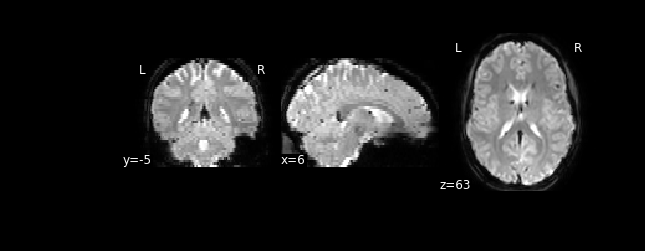

In [7]:
import nilearn.plotting as niplot
import nilearn.image as niimg

disp = niplot.plot_anat(niimg.index_img(fmri_img, 2), 
                        draw_cross=False, vmin=0, vmax=1800)

In [9]:
from matplotlib import animation
from joblib import Memory

memory = Memory('cache')

def update_fig(i, img, fig, kwargs):
    vol_img = niimg.index_img(img, i)
    
    plot_func = kwargs.pop('plot_func', niplot.plot_anat)
    
    disp = plot_func(vol_img, draw_cross=False, 
                     figure=fig, animated=True, **kwargs)
    return disp.frame_axes.artists


def niimg_animation(in_file, n_frames=None, **kwargs):
    """ Return a matplotlib.animation.FuncAnimation with """
    img = niimg.load_img(in_file)
    fig = plt.figure()

    if n_frames is None:
        n_frames = img.get_data().shape[-1]

    return animation.FuncAnimation(fig, update_fig, n_frames,
                                   fargs=(img, fig, kwargs),
                                   interval=1000, blit=True)

import io
import base64
from IPython.display import HTML

def embed_video(video_file):
    video = io.open(video_file, 'r+b').read()
    encoded = base64.b64encode(video)
    return HTML(data='''<video alt="test" width=1024 controls loop>
                      <source src="data:video/mp4;base64,{0}" type="video/mp4" />
                      </video>'''.format(encoded.decode('ascii')))

In [18]:
video_file = 'raw_fmri.mp4'

create_video = False
if create_video:
    anim = niimg_animation(fmri_img, n_frames=100, 
                           plot_func=niplot.plot_anat, 
                           cut_coords=[0, 10, 20],
                           vmin=0,
                           vmax=1430,
                          )

    # save the animation as an mp4.  This requires ffmpeg or mencoder to be
    # installed.  The extra_args ensure that the x264 codec is used, so that
    # the video can be embedded in html5.  You may need to adjust this for
    # your system: for more information, see
    # http://matplotlib.sourceforge.net/api/animation_api.html
    _ = anim.save(video_file, fps=5, extra_args=['-vcodec', 'libx264'])
    
embed_video(video_file)

# `Pre-processing`

## Trimming

Remove the first ~6secs of the fMRI data.

In [46]:
import math

def trim(in_file, tr=2, n_secs=6):
    begin_index = math.ceil(n_secs/tr)
    img = niimg.load_img(in_file)

    s = slice(begin_index, img.shape[3])

    return nib.Nifti1Image(img.get_data()[..., s], 
                           img.affine, img.header)

In [47]:
print(fmri_img.shape)

trimmed_img = trim(fmri_img, tr=2.5)

print(trimmed_img.shape)

(128, 128, 45, 162)
(128, 128, 45, 159)


## `Slice timing and motion correction`

<img src="imgs/stc_corr.png" width="75%"/>

Rest data was collected on a **Philips** Achieva Ds.

**Repetition Time (TR): 2.5s**

Echo-Time (TE): 30ms

**45 slices**

slice orientation: Axial plane

**slice scan order: ascend**

**Minimum number of packages =	1**

In [257]:
iframe('http://dbic.dartmouth.edu/wiki/index.php/Slice_Acquisition_Order')

In [22]:
from nipy.algorithms.slicetiming.timefuncs import st_01234

N_SLICES = 45
TR = 2.5

slice_times = st_01234(N_SLICES, TR)

print(slice_times)

[ 0.          0.05555556  0.11111111  0.16666667  0.22222222  0.27777778
  0.33333333  0.38888889  0.44444444  0.5         0.55555556  0.61111111
  0.66666667  0.72222222  0.77777778  0.83333333  0.88888889  0.94444444
  1.          1.05555556  1.11111111  1.16666667  1.22222222  1.27777778
  1.33333333  1.38888889  1.44444444  1.5         1.55555556  1.61111111
  1.66666667  1.72222222  1.77777778  1.83333333  1.88888889  1.94444444
  2.          2.05555556  2.11111111  2.16666667  2.22222222  2.27777778
  2.33333333  2.38888889  2.44444444]


In [23]:
from nipy.algorithms.registration.groupwise_registration import SpaceTimeRealign

realigner = SpaceTimeRealign(trimmed_img, 
                             tr=TR,
                             #slice_times='st_13024',
                             slice_times=slice_times,
                             slice_info=2,)

In [25]:
@memory.cache
def estimate_resample_realignment(fmri_img, **kwargs):
    realigner = SpaceTimeRealign(fmri_img, **kwargs) 
   
    realigner.estimate()

    realigned = realigner.resample()[0]
    
    return realigner, realigned

In [22]:
realigner, realigned = estimate_resample_realignment(CUR_FMRI_IMG, 
                                                     tr=TR,
                                                     #slice_times='st_13024',
                                                     slice_times=slice_times,
                                                     slice_info=2)

________________________________________________________________________________
[Memory] Calling __main__--Users-alexandre-Dropbox (Personal)-Documents-projects-ep16_talks-nipy-__ipython-input__.estimate_resample_realignment...
estimate_resample_realignment(<nibabel.nifti1.Nifti1Image object at 0x129d66c50>, tr=2.5, slice_times=array([ 0.      ,  0.055556,  0.111111,  0.166667,  0.222222,  0.277778,
        0.333333,  0.388889,  0.444444,  0.5     ,  0.555556,  0.611111,
        0.666667,  0.722222,  0.777778,  0.833333,  0.888889,  0.944444,
        1.      ,  1.055556,  1.111111,  1.166667,  1.222222,  1.277778,
        1.333333,  1.388889,  1.444444,  1.5     ,  1.555556,  1.611111,
        1.666667,  1.722222,  1.777778,  1.833333,  1.888889,  1.944444,
        2.      ,  2.055556,  2.111111,  2.166667,  2.222222,  2.277778,
        2.333333,  2.388889,  2.444444]), slice_info=2)
_________________________________estimate_resample_realignment - 833.5s, 13.9min


In [23]:
translations = [r.translation for r in realigner._transforms[0]]
xyzs         = [(x, y, z) for (x, y, z) in translations]

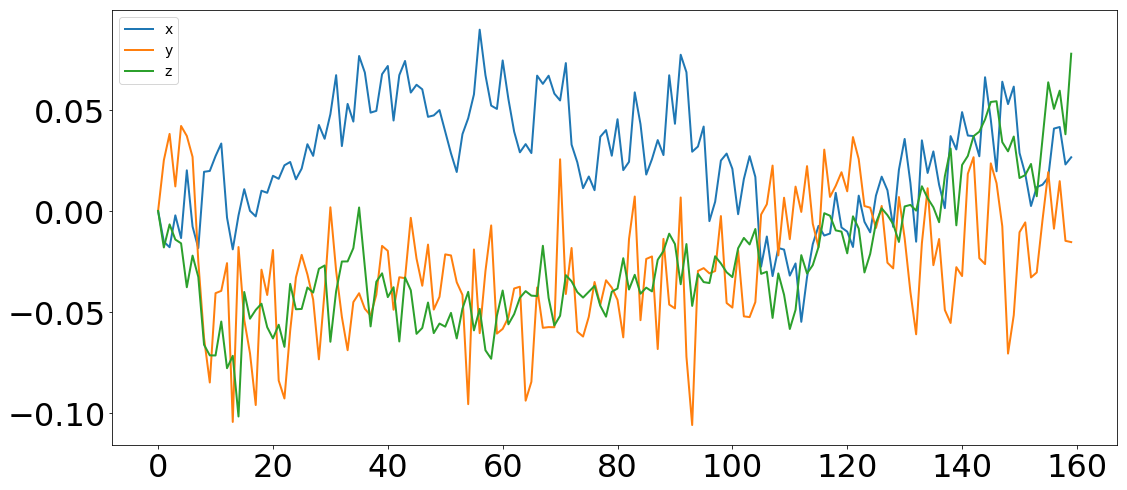

In [24]:
plt.plot(xyzs)
plt.legend(['x', 'y', 'z'])
plt.ylabel = 'estimated motion (mm)'
plt.xlabel = 'slice'

In [25]:
print(realigned.shape)

(128, 128, 45, 160)


In [26]:
type(realigned)

nipy.core.image.image.Image

In [32]:
from nipy import save_image

store_realigned_img = False
realigned_file = path.join(path.dirname(fmri_file), 'realigned.nii.gz')

if store_realigned_img:
    realigned_fmri_img = save_image(realigned, realigned_file)

realigned_img = nib.load(realigned_file)

In [28]:
trnsf = realigner._transforms[0][1]
trnsf.as_affine()

array([[  9.99999987e-01,  -2.44748575e-05,   1.57083901e-04,
         -1.52046169e-02],
       [  2.45294341e-05,   9.99999939e-01,  -3.47443366e-04,
          2.50899329e-02],
       [ -1.57075388e-04,   3.47447215e-04,   9.99999927e-01,
         -1.80545426e-02],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.00000000e+00]])

In [65]:
video_file = 'realigned_fmri.mp4'

create_video = False
if create_video:
    anim = niimg_animation(realigned_img, n_frames=100, 
                           plot_func=niplot.plot_anat, 
                           cut_coords=[6, -5, 63],
                           vmin=0,
                           vmax=1430,
                          )

    _ = anim.save(video_file, fps=5, extra_args=['-vcodec', 'libx264'])
    
embed_video(video_file)

## `Temporal signal filtering`

In the case of resting-state fMRI we are interested only in a specific time frequency band: 0.1Hz - 0.01Hz.

In [10]:
import nibabel as nb
import numpy as np

@memory.cache
def bandpass_filter(img_file, lowpass_freq=0.1, highpass_freq=0.01, tr=2):
    """Bandpass filter the input fMRI image.

    Parameters
    ----------
    img_file: str
        4d nifti file path.

    lowpass_freq: float
        Cutoff frequency for the low pass filter (in Hz).

    highpass_freq: float
        Cutoff frequency for the high pass filter (in Hz).

    tr: float
        The repetition time in seconds. The inverse of sampling rate (in Hz).
    """
    fs = 1./tr

    img = niimg.load_img(img_file)
    timepoints = img.shape[-1]
    F = np.zeros((timepoints))

    lowidx = int(timepoints / 2) + 1
    if lowpass_freq > 0:
        lowidx = np.round(float(lowpass_freq) / fs * timepoints)

    highidx = 0
    if highpass_freq > 0:
        highidx = np.round(float(highpass_freq) / fs * timepoints)

    F[int(highidx):int(lowidx)] = 1
    F = ((F + F[::-1]) > 0).astype(int)
    data = img.get_data()
    if np.all(F == 1):
        filtered_data = data
    else:
        filtered_data = np.real(np.fft.ifftn(np.fft.fftn(data) * F))

    return nb.Nifti1Image(filtered_data, img.affine, img.header)

In [28]:
filt_img = bandpass_filter(realigned_file, tr=TR)

________________________________________________________________________________
[Memory] Calling __main__--Users-alexandre-Dropbox (Personal)-Documents-projects-ep16_talks-nipy-__ipython-input__.bandpass_filter...
bandpass_filter('/Users/alexandre/data/abide/ABIDEII-KUL_3/29660/session_1/rest_1/realigned.nii.gz', tr=2.5)
_________________________________________________bandpass_filter - 72.3s, 1.2min


In [43]:
filtered_fmri_file = 'time_filtered.nii.gz'
filt_img.to_filename(filtered_fmri_file)

In [54]:
video_file = 'time_filtered_fmri.mp4'

create_video = False
if create_video:
    anim = niimg_animation(filt_img, n_frames=100, 
                           plot_func=niplot.plot_anat, 
                           cut_coords=[6, -5, 63],
                           vmin=-3,
                           vmax=25,
                          )

    _ = anim.save(video_file, fps=20, extra_args=['-vcodec', 'libx264'])
    
embed_video(video_file)

In [61]:
!fslview $filtered_fmri_file

fslview /Users/alexandre/Dropbox (Personal)/Documents/projects/ep16_talks/nipy/time_filtered.nii.gz &


## `Smoothing`

Not only making the image look nicer.

In [40]:
# Gaussian kernel with a full-width half-maximum of 8mm:
smooth_img = niimg.smooth_img(filt_img, fwhm=8)

smooth_img.to_filename('smooth_fmri.nii.gz')

In [70]:
video_file = 'smooth_fmri.mp4'

create_video = False
if create_video:
    anim = niimg_animation(smooth_img, n_frames=100, 
                           plot_func=niplot.plot_anat, 
                           cut_coords=[6, -5, 63],
                           vmin=-3,
                           vmax=25,
                          )

    _ = anim.save(video_file, fps=40, extra_args=['-vcodec', 'libx264'])
    
embed_video(video_file)

In [ ]:
!fslview smooth_fmri.nii.gz

## `Creating brain masks from fMRI`

Segmenting the brain from the rest of the image.

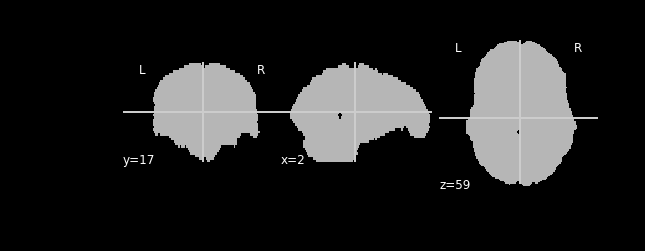

In [34]:
import nilearn.masking as nimask
import nilearn.plotting as niplot

msk_img = nimask.compute_epi_mask(realigned_img)

niplot.plot_anat(msk_img)

In [72]:
msk_img.shape

(128, 128, 45)

In [74]:
np.unique(msk_img.get_data())

array([0, 1], dtype=int8)

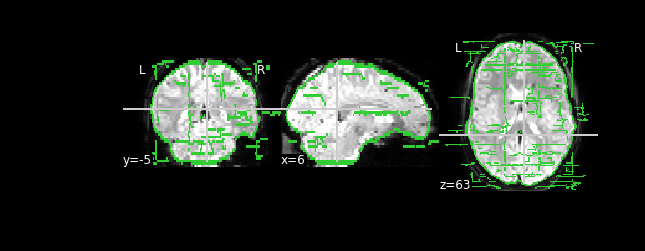

In [79]:
display = niplot.plot_anat(index_img(realigned_img, 0), vmin=0, vmax=1430)

display.add_edges(msk_img, color='limegreen') 

### Use structural image to perform segmentations

- aka T1-weighted

- best resolution and tissue contrast

/Users/alexandre/Software/nilearn/nilearn/image/resampling.py:468: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))


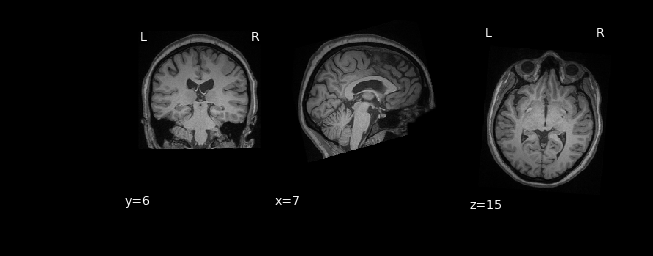

In [64]:
niplot.plot_anat(anatf, draw_cross=False)

In [ ]:
from nipype.interfaces import spm

seg = spm.NewSegment()
seg.inputs.channel_files = stru_file

seg_out = seg.run()

## `Spatial normalization`

All our brains are different, how do I localize different areas in each of them?

Many University software packages offer non-linear spatial normalization:

- FSL

- SPM12

- FreeSurfer

- ANTs

- AFNI

In [86]:
import nipype.interfaces.spm as spm

norm12 = spm.Normalize12(jobtype='estwrite')
norm12.inputs.image_to_align = anat_file
norm12_out = norm12.run()

In [90]:
out.

# `Brain atlas`

Localizing different regions in the brain.

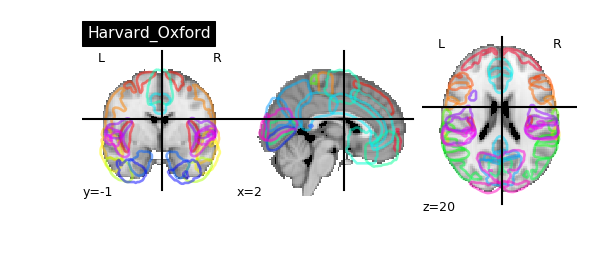

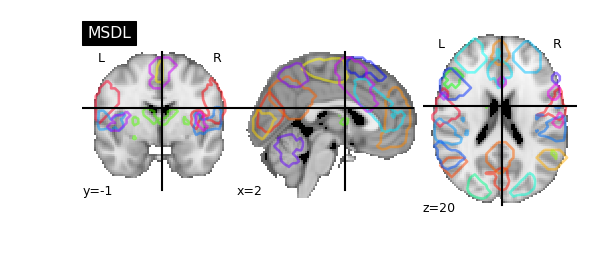

In [39]:
# Load 4D probabilistic atlases
from nilearn import datasets

# Harvard Oxford Atlasf
harvard_oxford = datasets.
fetch_atlas_harvard_oxford('cort-prob-2mm')

# Multi Subject Dictionary Learning Atlas
msdl = datasets.fetch_atlas_msdl()

# Visualization
from nilearn import plotting

atlas_types = {'Harvard_Oxford': harvard_oxford.maps,
               'MSDL': msdl.maps,}

for name, atlas in sorted(atlas_types.items()):
    plotting.plot_prob_atlas(atlas, title=name)

plotting.show()

# `Resting state networks`

Different areas in the brain that "sing together" while you rest.

<img src="imgs/rsns.jpg" width="400px"/>

## `Independent Component Analysis`

In the search for resting-state networks.

In [49]:
from nilearn.decomposition import CanICA

ica = CanICA(n_components=20, smoothing_fwhm=8.,
             memory="nilearn_cache", memory_level=2,
             threshold=3., verbose=10, random_state=0, mask=msk_img)

ica.fit(filt_img)

# Resting state networks spatial maps:
components_img = ica.masker_.inverse_transform(ica.components_)

[MultiNiftiMasker.fit] Loading data from None
[MultiNiftiMasker.transform] Resampling mask
________________________________________________________________________________
[Memory] Calling nilearn.image.resampling.resample_img...
resample_img(<nibabel.nifti1.Nifti1Image object at 0x10ece5e48>, target_affine=None, target_shape=None, interpolation='nearest', copy=False)
_____________________________________________________resample_img - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x1355bb7f0>, <nibabel.nifti1.Nifti1Image object at 0x10ece5e48>, { 'detrend': True,
  'high_pass': None,
  'low_pass': None,
  'smoothing_fwhm': 8.0,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, memory_level=1, memory=Memory(cachedir='nilearn_cache/joblib'), verbose=10, confounds=None, copy=True)
[Mu

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   38.8s remaining:    0.0s


_________________________________________________________fastica - 37.2s, 0.6min
________________________________________________________________________________
[Memory] Calling sklearn.decomposition.fastica_.fastica...
fastica(array([[ -2.595928e-03, ...,  -9.008452e-04],
       ..., 
       [ -3.359319e-05, ...,  -6.859806e-04]]), whiten=True, fun='cube', random_state=924231285)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.3min remaining:    0.0s


_________________________________________________________fastica - 36.5s, 0.6min
________________________________________________________________________________
[Memory] Calling sklearn.decomposition.fastica_.fastica...
fastica(array([[ -2.595928e-03, ...,  -9.008452e-04],
       ..., 
       [ -3.359319e-05, ...,  -6.859806e-04]]), whiten=True, fun='cube', random_state=1478610112)


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.9min remaining:    0.0s


_________________________________________________________fastica - 37.0s, 0.6min
________________________________________________________________________________
[Memory] Calling sklearn.decomposition.fastica_.fastica...
fastica(array([[ -2.595928e-03, ...,  -9.008452e-04],
       ..., 
       [ -3.359319e-05, ...,  -6.859806e-04]]), whiten=True, fun='cube', random_state=441365315)


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  2.5min remaining:    0.0s


_________________________________________________________fastica - 37.0s, 0.6min
________________________________________________________________________________
[Memory] Calling sklearn.decomposition.fastica_.fastica...
fastica(array([[ -2.595928e-03, ...,  -9.008452e-04],
       ..., 
       [ -3.359319e-05, ...,  -6.859806e-04]]), whiten=True, fun='cube', random_state=1537364731)


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  3.1min remaining:    0.0s


_________________________________________________________fastica - 36.6s, 0.6min
________________________________________________________________________________
[Memory] Calling sklearn.decomposition.fastica_.fastica...
fastica(array([[ -2.595928e-03, ...,  -9.008452e-04],
       ..., 
       [ -3.359319e-05, ...,  -6.859806e-04]]), whiten=True, fun='cube', random_state=192771779)


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  3.7min remaining:    0.0s


_________________________________________________________fastica - 36.7s, 0.6min
________________________________________________________________________________
[Memory] Calling sklearn.decomposition.fastica_.fastica...
fastica(array([[ -2.595928e-03, ...,  -9.008452e-04],
       ..., 
       [ -3.359319e-05, ...,  -6.859806e-04]]), whiten=True, fun='cube', random_state=1491434855)


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  4.3min remaining:    0.0s


_________________________________________________________fastica - 36.7s, 0.6min
________________________________________________________________________________
[Memory] Calling sklearn.decomposition.fastica_.fastica...
fastica(array([[ -2.595928e-03, ...,  -9.008452e-04],
       ..., 
       [ -3.359319e-05, ...,  -6.859806e-04]]), whiten=True, fun='cube', random_state=1819583497)


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  4.9min remaining:    0.0s


_________________________________________________________fastica - 38.1s, 0.6min
________________________________________________________________________________
[Memory] Calling sklearn.decomposition.fastica_.fastica...
fastica(array([[ -2.595928e-03, ...,  -9.008452e-04],
       ..., 
       [ -3.359319e-05, ...,  -6.859806e-04]]), whiten=True, fun='cube', random_state=530702035)


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  5.6min remaining:    0.0s


_________________________________________________________fastica - 36.8s, 0.6min


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  6.2min finished


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([[-0., ..., -0.],
       ..., 
       [-0., ..., -0.]]), <nibabel.nifti1.Nifti1Image object at 0x10ece5e48>)
___________________________________________________________unmask - 0.6s, 0.0min


In [50]:
def plot_ica_components(components_img, **kwargs):
    """ Plot the components IC spatial maps in a grid."""
    import math
    from nilearn.image import iter_img
    from nilearn.plotting import plot_stat_map
    from matplotlib import pyplot as plt
    from matplotlib import gridspec

    n_ics  = len(list(iter_img(components_img)))
    n_rows = math.ceil(n_ics/2)
    fig = plt.figure(figsize=(6, 3*n_rows), facecolor='black')
    gs  = gridspec.GridSpec(n_rows, 2)

    plots = []
    for i, ic_img in enumerate(iter_img(components_img)):
        ax = plt.subplot(gs[i])
        p  = plot_stat_map(ic_img, display_mode="z", title="IC {}".format(i+1),
                           cut_coords=1, colorbar=False, figure=fig, axes=ax, **kwargs)
        plots.append(p)

    for p in plots:
        p.close()

    return fig

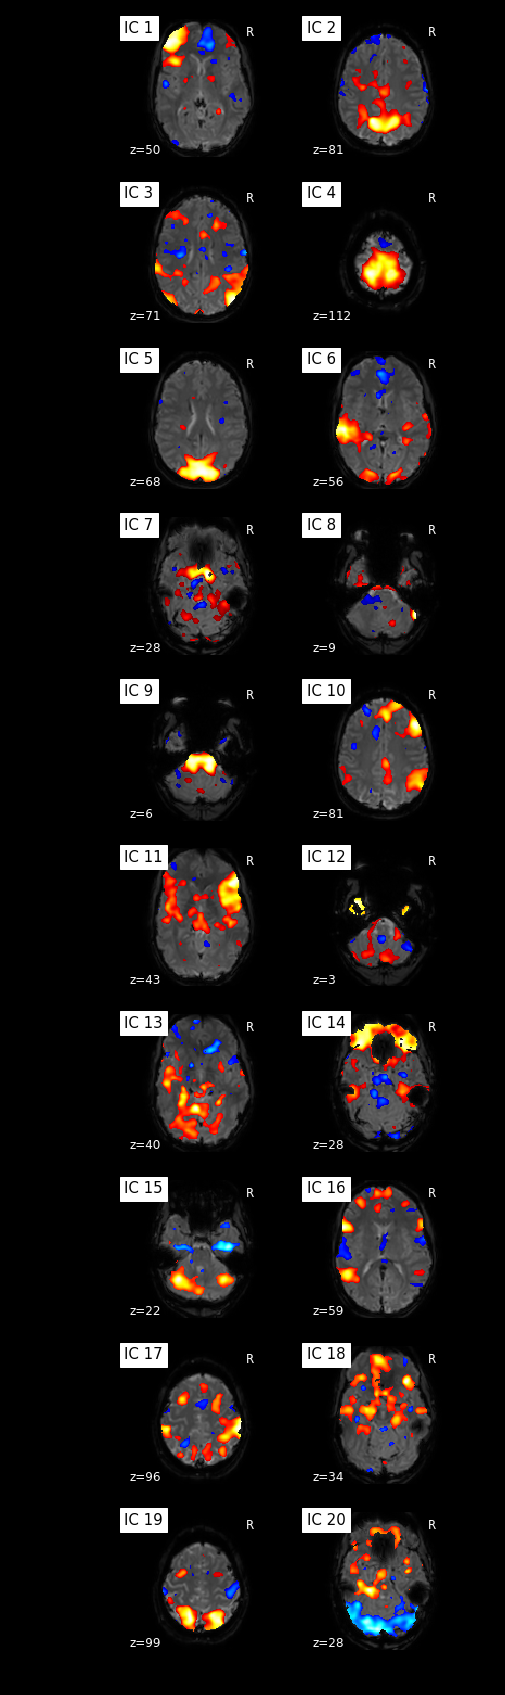

In [52]:
plot_ica_components(components_img, bg_img=niimg.index_img(fmri_img, 0))

## `http://github.com/neurita/neuro_docker`

<img src="imgs/logo.svg" width="25%"/> 

# `Questions?`


### My boss looks for a PhD student!
##### contact me for more details!


### `Contact`

<i class="fa fa-envelope-o fa-1g"></i> <a href="mailto:alexsavio@gmail.com">alexsavio@gmail.com</a>

<i class="fa fa-github fa-1g"></i> <a href="https://github.com/alexsavio/">alexsavio</a>

<i class="fa fa-twitter-square fa-1g"></i> <a href="https://twitter.com/alex_savio/">alex_savio</a>